# Ciencia de datos (CC408) - Primavera 2024

## Trabajo Práctico 3

## Parte 0: Paquetes a utilizar

In [1]:
#Paquetes y librerías a usar

#!pip install openpyxl
#!pip install statsmodels

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
#from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

## Parte I: Analizando la base

#### Lectura del documento

In [3]:
#Lectura del documento
df2024 = pd.read_excel('C:/Users/SAMSUNG/Documents/GitHub/CC408-T1-5/TP 3/usu_individual_T124.xlsx')
df2004 = pd.read_stata('C:/Users/SAMSUNG/Documents/GitHub/CC408-T1-5/TP 3/Individual_t104.dta')

#Dirección de Maggie: "C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 3"
#Dirección de Peter: "C:/Users/SAMSUNG/Documents/GitHub/CC408-T1-5/TP 3/usu_individual_T124.xlsx"

a. Eliminen todas las observaciones que no corresponden a los
aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos
Aires, y unan ambos trimestres en una sola base.

In [4]:
#Filtramos las bases para tener solo Buenos Aires
df_2024_GB = df2024[(df2024['AGLOMERADO'] == 33) | (df2024['AGLOMERADO'] == 32)]
df_2004_GB = df2004[(df2004['aglomerado'] == 'Ciudad de Buenos Aires') | (df2004 ['aglomerado'] == 'Partidos del GBA' )]

df_2004_GB.columns = df_2004_GB.columns.str.upper()
df_2024_GB['IPCF'] =df_2024_GB['IPCF'].astype(int)

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_13684\2033928064.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024_GB['IPCF'] =df_2024_GB['IPCF'].astype(int)


#### Se eliminan columnas antes de combinar bases

In [5]:
#IDENTIFICO COLUMNAS QUE DIFIEREN ENTRE LAS BASES
col2004 = df_2004_GB.columns
col2024 = df_2024_GB.columns

# Encontrar columnas que son diferentes
columnas_df1 = set(col2004)
columnas_df2 = set(col2024)

# Columnas en df1 pero no en df2
diferentes_df1 = columnas_df1 - columnas_df2
# Columnas en df2 pero no en df1
diferentes_df2 = columnas_df2 - columnas_df1

# Comparar columnas comunes para ver diferencias en valores
diferencias_valores = {}
for col in columnas_df1.intersection(columnas_df2):
    if not df_2004_GB[col].equals(df_2024_GB[col]):
        diferencias_valores[col] = (df_2004_GB[col].tolist(), df_2024_GB[col].tolist())

print("Columnas solo en 2004:", diferentes_df1)
print("Columnas solo en 2024:", diferentes_df2)
#print("Diferencias en valores:", diferencias_valores)


Columnas solo en 2004: {'PJ1_1', 'IDIMPP', 'PJ2_1', 'PJ3_1'}
Columnas solo en 2024: {'PONDIIO', 'CH05', 'PONDII', 'PONDIH', 'IMPUTA'}


In [6]:
#ELIMINO LAS COLUMNAS QUE DIFIEREN Y LAS QUE RESULTAN IRRELEVANTES
del_col1 = ['PJ3_1', 'IDIMPP', 'PJ2_1', 'PJ1_1', 'CODUSU']
del_col2 = ['IMPUTA', 'CH05', 'PONDII', 'PONDIH', 'PONDIIO','CODUSU']

df_2004_GB =df_2004_GB.drop(columns = del_col1)
df_2024_GB =df_2024_GB.drop(columns = del_col2)

# df_combined = df.drop(columns=['B', 'C'])

#### Se combinan las bases
b. Si hay observaciones con valores que no tienen sentido,
descártenlas (por ejemplo, ingresos y edades negativos). Expliquen
las decisiones tomadas.

In [7]:
# Uno ambos trimestres en una sola base
df_combined = pd.concat([df_2004_GB, df_2024_GB], ignore_index=True, sort=False)
df_combined["ANO4"] = df_combined["ANO4"].astype(int)


In [8]:
#Definición de algunas variables para uniformar diccionarios y unificar las bases
h04 = {
    "Varón": 1,
    "Mujer": 2
}

h06 = {
    'Menos de 1 año': 0,
    '98 y más años': 98
}

h07 = {
    "Unido": 1,
    "Casado": 2,
    "Separado o divorciado": 3,
    "Viudo": 4,
    "Soltero": 5
}

h08 =    {
    'Obra social (incluye PAMI)': 1,
    'Mutual/Prepaga/Servicio de emergencia': 2,
    'Planes y seguros públicos': 3,
    'No paga ni le descuentan': 4,
    'Ns./Nr.': 9,
    'Obra social y mutual/prepaga/servicio de emergencia': 12,
    'Obra social y planes y seguros públicos': 13,
    'Mutual/prepaga/servicio de emergencia/planes y seguros públi': 23,
    'Obra social, mutual/prepaga/servicio de emergencia y planes': 123
}

nivel_ed= {
    'Primaria Incompleta (incluye educación especial)': 1,
    'Primaria Completa': 2,
    'Secundaria Incompleta': 3,
    'Secundaria Completa': 4,
    'Superior Universitaria Incompleta': 5,
    'Superior Universitaria Completa': 6,
    'Sin instrucción': 7,
    'Ns/Nr': 9
}

estado = {
    'Entrevista individual no realizada (no respuesta al cuestion': 0,
    'Ocupado': 1,
    'Desocupado': 2,
    'Inactivo': 3,
    'Menor de 10 años': 4
}

cat_inac = {
    'Jubilado/pensionado': 1,
    'Rentista': 2,
    'Estudiante': 3,
    'Ama de casa': 4,
    'Menor de 6 años': 5,
    'Discapacitado': 6,
    'Otros': 7
}


componente = {
    'Servicio doméstico en hogares': 51
}

h15 = {
    "Sí": 1,
    "No": 2
}

mas_500 = {
    'N' : 1,
    'S' : 0
} 

aglomerado = {
    'Ciudad de Buenos Aires' : 32,
    'Partidos del GBA' : 33

}

ch03 = {
    'Jefe' : 1,
    'Cónyuge/Pareja' : 2,
    'Hijo/Hijastro' : 3,
    'Yerno/Nuera' : 4,
    'Nieto' : 5,
    'Madre/Padre' : 6,
    'Suegro' : 7,
    'Hermano' : 8,
    'Otros familiares' : 9,
    'No familiares' : 10,
}

ch09 = {
    "Sí": 1,
    "No": 2,
    "Menor de 2 años": 3,
    'Ns./Nr.' : 0 
}

ch10 = {
    "Sí, asiste": 1,
    "No asiste, pero asistió": 2,
    "Nunca asistió": 3  
}

In [37]:
df_combined.loc[:,'CAT_INAC'] = df_combined['CAT_INAC'].replace(cat_inac).astype(int) 
df_combined.loc[:,'CH04'] = df_combined['CH04'].replace(h04).astype(int)
df_combined.loc[:,'CH06'] = df_combined['CH06'].replace(h06).astype(int)
df_combined.loc[:,'CH07'] = df_combined['CH07'].replace(h07).astype(int)
df_combined.loc[:,'CH08'] = df_combined['CH08'].replace(h08).astype(int)
#df_combined.loc[:,'AGLOMERADO'] = df_combined['AGLOMERADO'].map(aglomerado).astype(int)
df_combined.loc[:,'NIVEL_ED'] = df_combined['NIVEL_ED'].replace(nivel_ed).astype(int)
df_combined.loc[:,'ESTADO'] = df_combined['ESTADO'].replace(estado).astype(int)
df_combined['IPCF'] = df_combined['IPCF'].astype(int)

df_combined.loc[:,'COMPONENTE'] = df_combined['COMPONENTE'].replace(componente).astype(int)
df_combined.loc[:,'H15'] = df_combined['H15'].replace(h15).astype(int)
df_combined.loc[:,'MAS_500'] = df_combined['MAS_500'].replace(mas_500).astype(int)
df_combined.loc[:,'AGLOMERADO'] = df_combined['AGLOMERADO'].replace(aglomerado).astype(int)
df_combined.loc[:, 'CH03'] = df_combined['CH03'].replace(ch03).astype(int)
df_combined.loc[:, 'CH09'] = df_combined['CH09'].replace(ch09).astype(int)  # hay 2 valores 9 que no deberían estar
df_combined.loc[:, 'CH10'] = df_combined['CH10'].replace(ch10).astype(int)  # hay 364 valores que son 0 y 2 que son 9 que no deberían ser

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_13684\3711807908.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined.loc[:,'CAT_INAC'] = df_combined['CAT_INAC'].replace(cat_inac).astype(int)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_13684\3711807908.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined.loc[:,'CH04'] = df_combined['CH04'].replace(h04).astype(int)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_13684\3711807908.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be rem

In [38]:
valores_validos = {
    'CH04': [1,2],
    'CH07': [1,2,3,4,5],
    'CH08': [1,2,3,4,9,12,13,23,123],
    'NIVEL_ED': [1,2,3,4,5,6,7,8,9],
    'ESTADO': [0,1,2,3,4],
    'CAT_INAC': [0,1,2,3,4,5,6,7] 
} #'CH06' Y 'IPCF' quedan excluidos porque tiene condiciones de min y max

for col in valores_validos.keys():
    df_combined = df_combined[df_combined[col].isin(valores_validos[col])]

In [39]:
# Define los límites
maximo_edad = 130 # totalmente arbitrario, pero sirve para sacar extraños muy extraños

# Filtra el DataFrame, manteniendo solo los valores dentro del rango
df_combined = df_combined[(df_combined['IPCF'] >= 0)]
df_combined = df_combined[(df_combined['CH06'] >= 0) & (df_combined['CH06'] <= maximo_edad)]

In [13]:
df_combined

,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,...,GDECIFR,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR
0,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Jefe,...,02,,01,368,07,,06,06,,04
1,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,2018.0,Jefe,...,00,,00,0,00,,00,00,,00
2,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Jefe,...,03,,02,440,07,,07,07,,05
3,1.0,1.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Jefe,...,09,,08,532,08,,08,08,,06
4,1.0,2.0,Sí,2004,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Cónyuge/Pareja,...,09,,08,532,08,,08,08,,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14693,1.0,1,1,2024,1,1,S,33,3410.0,1,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
14694,1.0,2,2,2024,1,1,S,33,3410.0,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
14695,1.0,3,2,2024,1,1,S,33,3410.0,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12
14696,1.0,4,2,2024,1,1,S,33,3410.0,3,...,12.0,NaN,12,0,12,NaN,12,12.0,NaN,12


## Parte 1.5: Visualizaciones

2. c. realicen un gráfico de barras
mostrando la composición por sexo para 2004 y 2024.

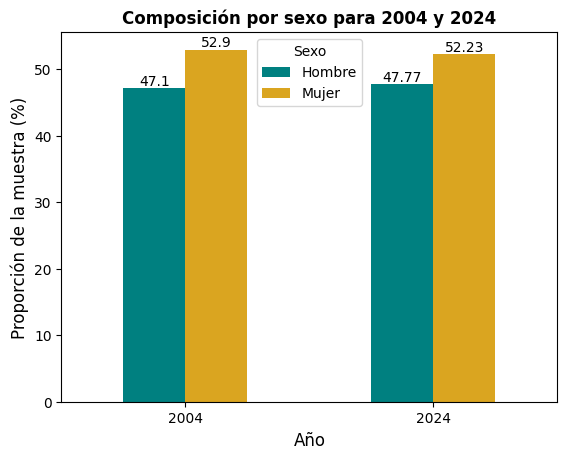

In [40]:
# #COMPOSICIÓN POR SEXO PARA 2004 Y 2024
    # #CH04: Sexo. 1=Varón, 2=Mujer
    # #ANO4: Año (2004, 2024)

#Definición de variables de composición por sexo
comp_sexo = df_combined.groupby(['ANO4', 'CH04']).size().unstack(fill_value=0)
comp_ano = df_combined.groupby(['ANO4']).size()
comp_sexo_prop = round(comp_sexo.div(comp_ano, axis = 0)*100, 2)

#Gráfico de barras
colores = ["teal", "goldenrod"]
ax = comp_sexo_prop.plot(kind='bar', color=colores)
ax.set_title('Composición por sexo para 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año', fontdict={'fontsize': 12})
ax.set_ylabel('Proporción de la muestra (%)', fontdict={'fontsize': 12})
plt.xticks(rotation=0)
plt.legend(['Hombre', 'Mujer'], title='Sexo', loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1)

for container in ax.containers:
    ax.bar_label(container)

plt.show()


2. d. una matriz de correlación para 2004 y 2024 con las
siguientes variables: CH04, CH06, CH07, CH08, NIVEL ED,
ESTADO, CAT_INAC, IPCF.

Text(0.5, 1.0, 'Matriz de correlación - 2004')

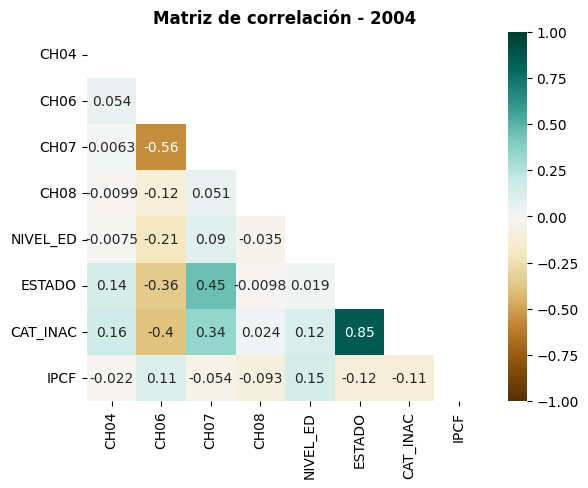

In [41]:
##MATRIZ DE CORRELACIÓN

#Selección de variables para la matriz de correlación y armado de las matrices
col_cor = ["CH04", "CH06", "CH07", 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']
df_cor2004 = df_combined[df_combined['ANO4'] == 2004][col_cor]
df_cor2024 = df_combined[df_combined['ANO4'] == 2024][col_cor]

#Matriz de correlación 2004
upp_mat2004 = np.triu(df_cor2004.corr())
cor04 = sns.heatmap(df_cor2004.corr(), vmin=-1, vmax=+1, annot=True, cmap="BrBG", mask=upp_mat2004)
cor04.set_title("Matriz de correlación - 2004",fontdict={'fontsize': 12, 'fontweight': 'bold'})


Text(0.5, 1.0, 'Matriz de correlación - 2024')

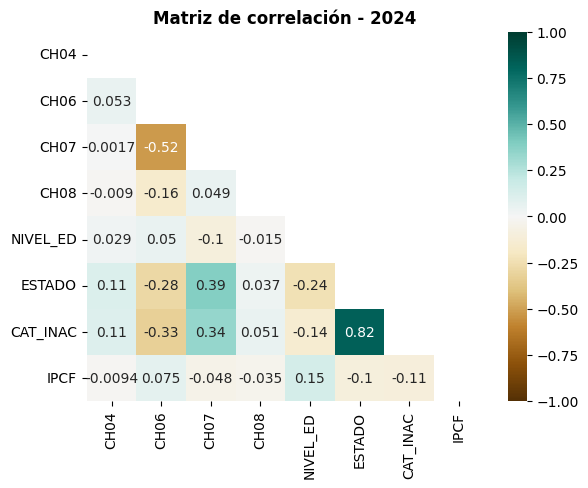

In [20]:
#Matriz de correlación 2024
upp_mat2024 = np.triu(df_cor2024.corr())
cor24 = sns.heatmap(df_cor2024.corr(), vmin=-1, vmax=+1, annot=True, cmap="BrBG", mask=upp_mat2024)
cor24.set_title("Matriz de correlación - 2024", fontdict={'fontsize': 12, 'fontweight': 'bold'})

2. e.

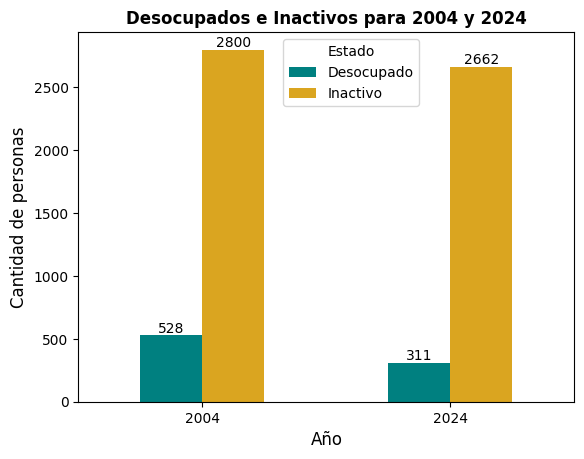

In [21]:
#Definición de variables de composición por estado de ocupación
comp_estado = df_combined.groupby(['ANO4', 'ESTADO']).size().unstack(fill_value=0)
comp_estado = comp_estado[[2,3]]

#Gráfico de barras
colores = ["teal", "goldenrod"]
ax = comp_estado.plot(kind='bar', color=colores)
ax.set_title('Desocupados e Inactivos para 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año', fontdict={'fontsize': 12})
ax.set_ylabel('Cantidad de personas', fontdict={'fontsize': 12})
plt.xticks(rotation=0)
plt.legend(['Desocupado', 'Inactivo'], title='Estado', loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=1)
plt.subplots_adjust()

for container in ax.containers:
    ax.bar_label(container)

plt.show()

In [22]:
#INGRESO PER CÁPITA FAMILIAR SEGÚN ESTADO (OCUPADO, DESOCUPADO, INACTIVO)
#IPCF: Monto de ingreso per capita familiar percibido
#ESTADO: 0 = Entrevista individual no realizada (no respuesta al cuestionario individual)
    # 1 = Ocupado
    # 2 = Desocupado
    # 3 = Inactivo
    # 4 = Menor de 10 años
# agg=['mean', 'count', 'min', 'max']
print("IPCF por estado, total\n", df_combined["IPCF"].groupby(df_combined["ESTADO"]).describe()) #PODRIAMOS SACAR LOS VALORES DE INGRESO EN CERO??
print("IPCF por estado, 2004\n", df_2004_GB["IPCF"].groupby(df_2004_GB["ESTADO"]).describe())
print("IPCF por estado, 2024\n", df_2024_GB["IPCF"].groupby(df_2024_GB["ESTADO"]).describe())


IPCF por estado, total
          count           mean            std  min   25%    50%       75%  \
ESTADO                                                                     
0         38.0      13.815789      53.735013  0.0   0.0    0.0      0.00   
1       6303.0  106443.281295  382731.337327  0.0  50.0  337.0  79800.00   
2        839.0   31655.797378   81410.436494  0.0  65.0  183.0    705.00   
3       5462.0   63862.957342  175238.209647  0.0  66.0  251.0  66750.00   
4       1992.0   40220.365964  120048.473873  0.0  60.0  180.5    825.25   

               max  
ESTADO              
0            294.0  
1       11312333.0  
2         908750.0  
3        5875000.0  
4        1733333.0  
IPCF por estado, 2004
                                                      count        mean  \
ESTADO                                                                   
Entrevista individual no realizada (no respuest...    10.0   52.533333   
Ocupado                                            

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_13684\3834964675.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("IPCF por estado, 2004\n", df_2004_GB["IPCF"].groupby(df_2004_GB["ESTADO"]).describe())


3, 4, 5 y 6

In [42]:
#ARMAR BASE DE RESPONDIERON Y NO RESPONDIERON

respondieron= df_combined.loc[(df_combined["ESTADO"]>0)]

norespondieron = df_combined.loc[(df_combined["ESTADO"]==0)] #38 personas no respondieron. 

def det_pea(estado): 
    return 1 if estado in [1,2] else 0

respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)
norespondieron["PEA"]= norespondieron["ESTADO"].apply(det_pea)

def det_pet(edad): 
    return 1 if 15 <= edad <= 65 else 0

respondieron["PET"]= respondieron["CH06"].apply(det_pet)
norespondieron["PET"]= norespondieron["CH06"].apply(det_pet)

def det_deso(estado): 
    return 1 if estado == 2 else 0

respondieron["desocupado"]= respondieron["ESTADO"].apply(det_deso)

def det_edadagrup(edad):
    if 15 <= edad < 25: 
        return "15-24"
    elif 25 <= edad < 35: 
        return "25-34"
    elif 35 <= edad < 45: 
        return "35-44"
    elif 45 <= edad < 55: 
        return "45-54"
    elif 55 <= edad <= 65: 
        return "55-65"
    else: 
        return "No PET"
    
    #return "15-24" if 15 <= edad < 25 else "25-34" if 25 <= edad < 35 else "35-44" if 35 <= edad < 45 else "45-54" if 45 <= edad < 55 else "55-65" if 55 <= edad <= 65 else 0

respondieron["edad_grupo"]= respondieron["CH06"].apply(det_edadagrup)


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_13684\4235542829.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["PEA"]= respondieron["ESTADO"].apply(det_pea)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_13684\4235542829.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norespondieron["PEA"]= norespondieron["ESTADO"].apply(det_pea)
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_13684\4235542829.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

Total PET: 9568
Total PEA: 7142


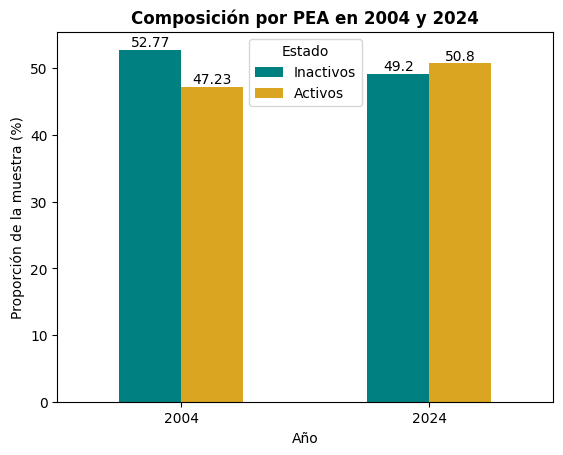

In [43]:
# Definición de variables que agrupan datos por año y PEA
comp_pea = respondieron.groupby(['ANO4', 'PEA']).size().unstack(fill_value=0)
comp_ano_r = respondieron.groupby(['ANO4']).size()
comp_pea_prop = round(comp_pea.div(comp_ano_r, axis = 0)*100, 2)
labels= (comp_pea_prop)

# Comparamos valores PET y PEA
total_pet = respondieron['PET'].sum()
total_pea = respondieron['PEA'].sum()

print(f'Total PET: {total_pet}')
print(f'Total PEA: {total_pea}')

# Gráfico de barras para PEA
colores = ["teal", "goldenrod"]
ax = comp_pea_prop.plot(kind='bar', color=colores)
ax.set_title('Composición por PEA en 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año')
ax.set_ylabel('Proporción de la muestra (%)')
plt.xticks(rotation=0)
plt.legend(['Inactivos', 'Activos'], title='Estado', loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1)

for container in ax.containers:
     ax.bar_label(container)

plt.show()


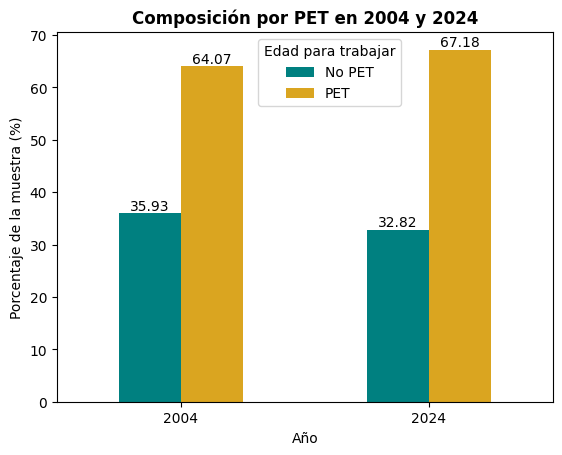

In [44]:
#Definición de variables que agrupan datos por año y PET
comp_pet = respondieron.groupby(['ANO4', 'PET']).size().unstack(fill_value=0)
comp_ano_r = respondieron.groupby(['ANO4']).size()
comp_pet_prop = round(comp_pet.div(comp_ano_r, axis = 0)*100, 2)

#Gráfico de barras para PET
colores = ["teal", "goldenrod"]
ax = comp_pet_prop.plot(kind='bar', color=colores)
ax.set_title('Composición por PET en 2004 y 2024', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje de la muestra (%)')
plt.xticks(rotation=0)
plt.legend(['No PET', 'PET'], title='Edad para trabajar', loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=1) #arreglar position

#Agregar etiquetas de altura a las barras
for container in ax.containers:
     ax.bar_label(container)

plt.show()

In [45]:
#Cantidad de desocupados por año
respondieron["desocupado"].groupby(respondieron["ANO4"]).value_counts()

ANO4  desocupado
2004  0             7109
      1              528
2024  0             6648
      1              311
Name: count, dtype: int64

In [46]:
#Cantidad de desocupados y ocupados por nivel educativo
respondieron["desocupado"].groupby(respondieron["NIVEL_ED"]).value_counts()

NIVEL_ED  desocupado
1         0             2226
          1               45
2         0             2223
          1              142
3         0             2614
          1              162
4         0             2417
          1              267
5         0             1419
          1              156
6         0             1685
          1               64
7         0             1173
          1                3
Name: count, dtype: int64

In [47]:
#Cantidad de personas por nivel educativo y por año
respondieron["NIVEL_ED"].groupby(respondieron['ANO4']).value_counts()

ANO4  NIVEL_ED
2004  2           1625
      1           1405
      3           1372
      4           1083
      7            805
      5            700
      6            647
2024  4           1601
      3           1404
      6           1102
      5            875
      1            866
      2            740
      7            371
Name: count, dtype: int64

In [48]:
#Data frame solo con desocupados para hacer visualizaciones
deso_df = respondieron.query("desocupado == 1") 

deso_df["NIVEL_ED"].groupby(deso_df['ANO4']).value_counts()

ANO4  NIVEL_ED
2004  4           137
      2           107
      3           107
      5            95
      1            43
      6            36
      7             3
2024  4           130
      5            61
      3            55
      2            35
      6            28
      1             2
Name: count, dtype: int64

In [49]:
#Cantidad de desocupados por año y nivel educativo
deso_df.groupby(['ANO4', 'NIVEL_ED']).size().unstack(fill_value=0)

NIVEL_ED,1,2,3,4,5,6,7
ANO4,,,,,,,
2004,43,107,107,137,95,36,3
2024,2,35,55,130,61,28,0


In [50]:
#Cantidad de desocupados por año y edad agrupado
deso_df.groupby(['ANO4', 'edad_grupo']).size().unstack(fill_value=0)

edad_grupo,15-24,25-34,35-44,45-54,55-65,No PET
ANO4,,,,,,
2004,209,124,60,58,58,19
2024,108,64,51,49,30,9


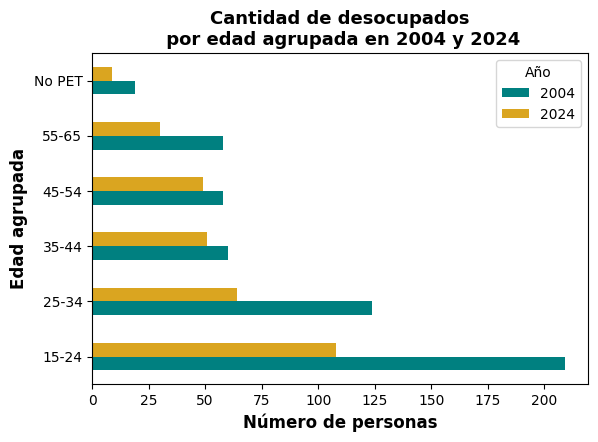

In [51]:
#Variable de cantidad de desocupados por edad agrupada por año
comp_deso_edad = deso_df.groupby([ 'edad_grupo', 'ANO4']).size().unstack(fill_value=0)


#Gráfico de barras horizontales
ax = comp_deso_edad.plot(kind='barh', color=colores)
ax.set_title('Cantidad de desocupados\n por edad agrupada en 2004 y 2024', fontdict={'fontsize': 13, 'fontweight': 'bold'})
ax.set_xlabel('Número de personas', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_ylabel('Edad agrupada', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.yticks(rotation=0)

edadagrupada = ["15-24", "25-34","35-44","45-54","55-65","No PET"]
ax.set_yticklabels(edadagrupada)

plt.legend(['2004', '2024'], title='Año', loc='upper center', bbox_to_anchor=(0.9, 1.0), ncol=1)
plt.subplots_adjust(top=0.8)


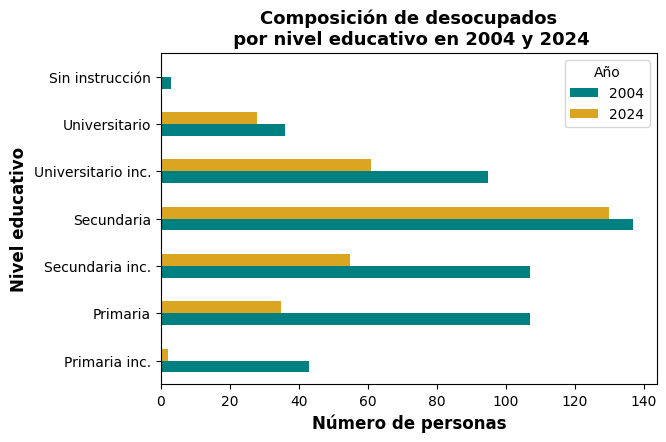

In [52]:
#Defino variables: agrupación de desocupados por nivel educativo y por año
comp_deso = deso_df.groupby(['NIVEL_ED', 'ANO4']).size().unstack(fill_value=0)
colores = ["teal", "goldenrod"]

#Gráfico de barras horizontales
ax = comp_deso.plot(kind='barh', color=colores)
ax.set_title('Composición de desocupados\n por nivel educativo en 2004 y 2024', fontdict={'fontsize': 13, 'fontweight': 'bold'})
ax.set_xlabel('Número de personas', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_ylabel('Nivel educativo', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.yticks(rotation=0)

niveleducativo = ['Primaria inc.', 'Primaria', 'Secundaria inc.', 'Secundaria', 'Universitario inc.', 'Universitario', 'Sin instrucción']  # Ejemplo de nuevos nombres
ax.set_yticklabels(niveleducativo)

plt.legend(['2004', '2024'], title='Año', loc='upper center', bbox_to_anchor=(0.9, 1.0), ncol=1)
plt.subplots_adjust(top=0.8)


## Parte II: Clasificaciones
El objetivo de esta parte del trabajo es intentar predecir si una persona está
desocupada o no utilizando distintas variables de características individuales.

##### Limpieza de Nans de base respondieron /no respondieron

In [53]:
lista_nans = respondieron.columns[respondieron.isnull().any()].tolist()
respondieron = respondieron.drop(lista_nans, axis=1)
respondieron = respondieron.drop('P47T', axis=1) #era la unica difereten con norespondieron

In [54]:
lista_nans = norespondieron.columns[norespondieron.isnull().any()].tolist()
norespondieron = norespondieron.drop(lista_nans, axis=1)

In [55]:
noresp_04 = norespondieron[norespondieron['ANO4'] == 2004]
noresp_24 = norespondieron[norespondieron['ANO4'] == 2024]
noresp_04 = noresp_04.select_dtypes(include='number')
noresp_24 = noresp_24.select_dtypes(include='number')

#### División de train y test para respondieron

1. Hago un df más chico por cada año, que elimina todas las variables categoricas
2. Defino X e y
3. PARTE 2, EJ1: Para cada año, partan la base respondieron en una base de prueba
(test) y una de entrenamiento (train) utilizando el comando
train_test_split. La base de entrenamiento debe comprender el 70%
de los datos, y la semilla a utilizar (random state instance) debe ser 101.
Establezca a desocupado como su variable dependiente en la base de
entrenamiento (vector y). El resto de las variables serán las variables
independientes (matriz X). Recuerden agregar la columna de unos (1).

In [56]:
again_04 = respondieron[respondieron['ANO4'] == 2004]
again_24 = respondieron[respondieron['ANO4'] == 2024]
again_04_selec = again_04.select_dtypes(include='number') # Se seleccionan solo las columnas numericas
again_24_selec = again_24.select_dtypes(include='number')

In [57]:
# Se separa X e y a partir de la selección de columnas numericas
X_2004 = again_04_selec.drop(columns=['desocupado'])
y_2004 = again_04_selec['desocupado']
X_2024 = again_24_selec.drop(columns=['desocupado'])
y_2024 = again_24_selec['desocupado']

In [60]:

x_train_24, x_test_24, y_train_24, y_test_24 = train_test_split(X_2024, y_2024, test_size=0.3, random_state=101)
x_train_04, x_test_04, y_train_04, y_test_04 = train_test_split(X_2004, y_2004, test_size=0.3, random_state=101)

x_train_04 = sm.add_constant(x_train_04) #AGREGO COLUMNA DE UNOS
x_train_24 = sm.add_constant(x_train_24)


### METODOS DE CLASIFICACIÓN
PARTE 2, EJ2: Implementen los siguientes métodos reportando luego la matriz de
confusión, la curva ROC, los valores de AUC y de Accuracy de cada uno:
● Regresión logística
● Análisis discriminante lineal
● KNN con k=3
● Naive Bayes

#### Regresión logistica

In [61]:
#### Regresion logistica para 2004
log04 = LogisticRegression(penalty=None).fit(x_train_04, y_train_04)
y_test_pred_score_04 = log04.predict_proba(x_train_04)[:,1]
y_pred_log04 = log04.predict(x_test_04)

#### Regresion logistica para 2024
log24 = LogisticRegression(penalty=None).fit(x_train_24, y_train_24)
y_test_pred_score_24 = log24.predict_proba(x_train_24)[:,1]
y_pred_log24 = log24.predict(x_test_24)

c:\Users\SAMSUNG\AnitaConda7\envs\Clasestuto\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\SAMSUNG\AnitaConda7\envs\Clasestuto\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

##### 2004

Matriz de confusion (Reg Log 2004)
 [[2128    5]
 [ 154    5]]

AUC Reg Log (2004): 0.5146


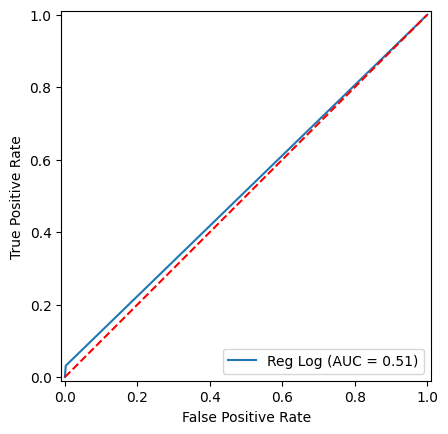

La accuracy del modelo (Reg Log 2004) es: 0.9306


In [62]:
#### Medidas de precision Regresion logistica para 2004
#Matriz de confusion
conflog04 = confusion_matrix(y_test_04, y_pred_log04) 
print("Matriz de confusion (Reg Log 2004)\n", conflog04)

#AUC
auc_log04 = roc_auc_score(y_test_04, y_pred_log04)
print('\nAUC Reg Log (2004): %.4f' %auc_log04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_log04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log04, estimator_name='Reg Log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_log04 = accuracy_score(y_test_04, y_pred_log04)
print("La accuracy del modelo (Reg Log 2004) es: %.4f" %accuracy_log04)

##### 2024

Matriz de confusion (Reg Log 2024)
 [[1995    1]
 [ 105    2]]

AUC Reg Log (2024): 0.5091


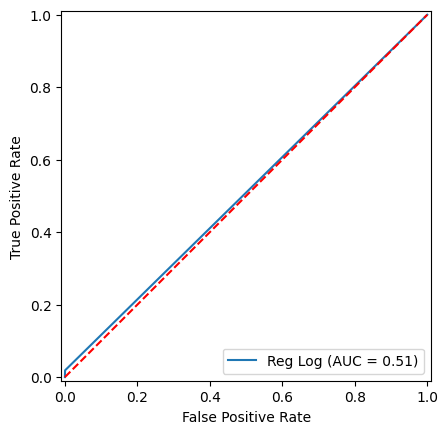

La accuracy del modelo (Reg Log 2024) es: 0.9496


In [40]:
#### Medidas de precision Regresion logistica para 2024
#Matriz de confusion
conflog24 = confusion_matrix(y_test_24, y_pred_log24) 
print("Matriz de confusion (Reg Log 2024)\n", conflog24)

#AUC
auc_log24 = roc_auc_score(y_test_24, y_pred_log24)
print('\nAUC Reg Log (2024): %.4f' %auc_log24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_log24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log24, estimator_name='Reg Log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_log24 = accuracy_score(y_test_24, y_pred_log24)
print("La accuracy del modelo (Reg Log 2024) es: %.4f" %accuracy_log24)

#### Estandarización de variables para LDA y KNN

In [73]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# Estandarizamos las observaciones de entrenamiento
x_train_04est = pd.DataFrame(sc.fit_transform(x_train_04), index=x_train_04.index, columns=x_train_04.columns)
x_train_24est = pd.DataFrame(sc.fit_transform(x_train_24), index=x_train_24.index, columns=x_train_24.columns)

# Estandarizamos las observaciones de test
x_test_04est = pd.DataFrame(sc.transform(x_test_04), index=x_test_04.index, columns=x_test_04.columns) 
x_test_24est = pd.DataFrame(sc.transform(x_test_24), index=x_test_24.index, columns=x_test_24.columns) 

#### LDA

##### 2004

In [66]:
#### LDA para 2004
lda04 = LinearDiscriminantAnalysis(n_components=1)
lda04 = lda04.fit(x_train_04, y_train_04)
y_pred_lda04 = lda04.predict(x_test_04)

#### LDA para 2024
lda24 = LinearDiscriminantAnalysis(n_components=1)
lda24 = lda24.fit(x_train_24, y_train_24)
y_pred_lda24 = lda24.predict(x_test_24)

Matriz de confusion (LDA 2004)
 [[2123   10]
 [ 154    5]]

AUC LDA (2004): 0.5134


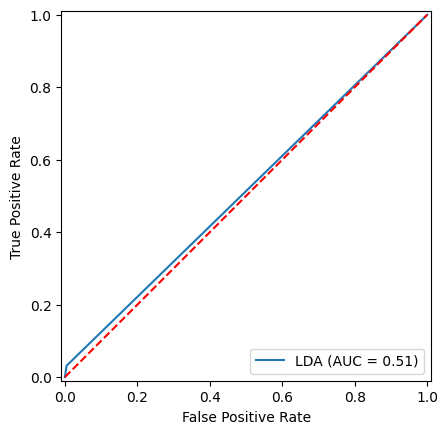

La accuracy del modelo (2004) es: 0.9284


In [67]:
#### Medidas de precision LDA para 2004
#Matriz de confusion
conflda04 = confusion_matrix(y_test_04, y_pred_lda04) 
print("Matriz de confusion (LDA 2004)\n", conflda04)

#AUC
auc_lda04 = roc_auc_score(y_test_04, y_pred_lda04)
print('\nAUC LDA (2004): %.4f' %auc_lda04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_lda04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lda04, estimator_name='LDA')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_lda04 = accuracy_score(y_test_04, y_pred_lda04)
print("La accuracy del modelo (2004) es: %.4f" %accuracy_lda04)


##### 2024

Matriz de confusion (LDA 2024)
 [[1983    5]
 [  99    1]]

AUC LDA (2024) 0.5037424547283702


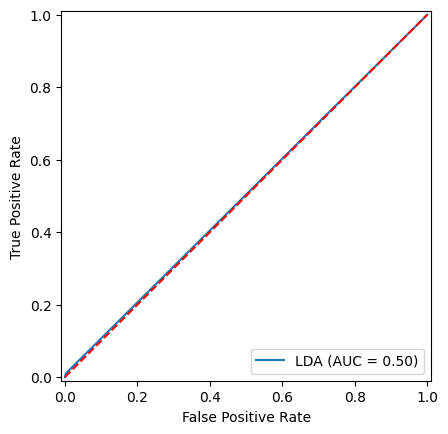

La accuracy del modelo (2024) es:  0.9501915708812261


In [68]:
#### Medidas de precision LDA para 2024
#Matriz de confusion
conflda24 = confusion_matrix(y_test_24, y_pred_lda24) 
print("Matriz de confusion (LDA 2024)\n", conflda24)

#AUC
auc_lda24 = roc_auc_score(y_test_24, y_pred_lda24)
print('\nAUC LDA (2024)', auc_lda24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_lda24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lda24, estimator_name='LDA')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_lda24 = accuracy_score(y_test_24, y_pred_lda24)
print("La accuracy del modelo (2024) es: ", accuracy_lda24)

##### 2004 estandarizado

Matriz de confusion (LDA 2004)
 [[1221  912]
 [   0  159]]

AUC LDA (2004) 0.7862165963431786


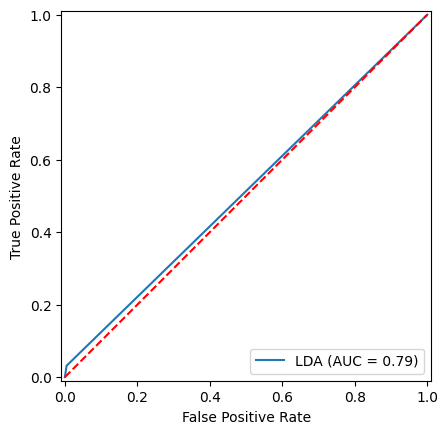

La accuracy del modelo (2004) es:  0.9284467713787086


In [74]:
lda04_est = LinearDiscriminantAnalysis(n_components=1)
lda04_est = lda04_est.fit(x_train_04est, y_train_04)
y_pred_lda04_est = lda04_est.predict(x_test_04est)

#### Medidas de precision LDA estandarizado para 2024
#Matriz de confusion
conflda04_est = confusion_matrix(y_test_04, y_pred_lda04_est) 
print("Matriz de confusion (LDA 2004)\n", conflda04_est)

#AUC
auc_lda04_est = roc_auc_score(y_test_04, y_pred_lda04_est)
print('\nAUC LDA (2004)', auc_lda04_est)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_lda04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lda04_est, estimator_name='LDA')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_lda04_est = accuracy_score(y_test_04, y_pred_lda04)
print("La accuracy del modelo (2004) es: ", accuracy_lda04_est)

##### 2024 estandarizado

Matriz de confusion (LDA 2024)
 [[1983    5]
 [  99    1]]

AUC LDA estandarizado (2024) 0.5037424547283702


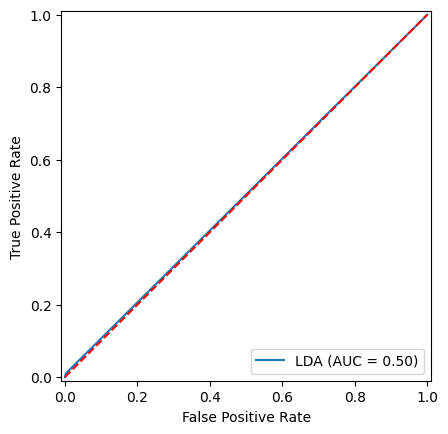

La accuracy del modelo estandarizado (2024) es:  0.9501915708812261


In [87]:
lda24_est = LinearDiscriminantAnalysis(n_components=1)
lda24_est = lda04_est.fit(x_train_24est, y_train_24)
y_pred_lda24_est = lda24_est.predict(x_test_24est)

#### Medidas de precision LDA estandarizado para 2024
#Matriz de confusion
conflda24_est = confusion_matrix(y_test_24, y_pred_lda24_est) 
print("Matriz de confusion (LDA 2024)\n", conflda24_est)

#AUC
auc_lda24_est = roc_auc_score(y_test_24, y_pred_lda24_est)
print('\nAUC LDA estandarizado (2024)', auc_lda24_est)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_lda24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lda24, estimator_name='LDA')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_lda24_est = accuracy_score(y_test_24, y_pred_lda24)
print("La accuracy del modelo estandarizado (2024) es: ", accuracy_lda24_est)

#### KNN

In [76]:
#### KNN para 2004

knn04 = KNeighborsClassifier(n_neighbors=3)
knn04.fit(x_train_04, y_train_04)
y_pred_knn04 = knn04.predict(x_test_04)

#### KNN para 2024
knn24 = KNeighborsClassifier(n_neighbors=3)
knn24.fit(x_train_24, y_train_24)
y_pred_knn24 = knn24.predict(x_test_24)

##### 2004

Matriz de confusion (KNN 2004)
 [[2087   46]
 [ 137   22]]

AUC KNN (2004): 0.5584


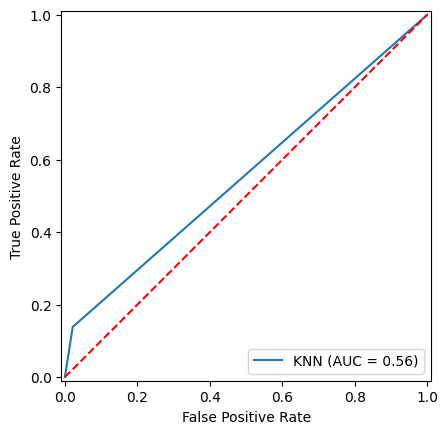

La accuracy del modelo KNN (2004) es: 0.9202


In [77]:
#Medidas de precision KNN (2004)
confknn04 = confusion_matrix(y_test_04, y_pred_knn04) 
print("Matriz de confusion (KNN 2004)\n", confknn04)

#AUC
auc_knn04 = roc_auc_score(y_test_04, y_pred_knn04)
print('\nAUC KNN (2004): %.4f' %auc_knn04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_knn04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_knn04, estimator_name='KNN')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_knn04 = accuracy_score(y_test_04, y_pred_knn04)
print("La accuracy del modelo KNN (2004) es: %.4f" %accuracy_knn04)

##### 2024

Matriz de confusion (KNN 2024)
 [[1961   27]
 [  94    6]]

AUC KNN (2024): 0.5232


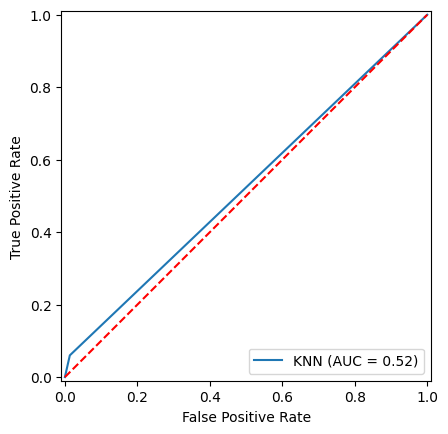

La accuracy del modelo KNN (2024) es: 0.9420


In [78]:
#Medidas de precision KNN (2024)
confknn24 = confusion_matrix(y_test_24, y_pred_knn24) 
print("Matriz de confusion (KNN 2024)\n", confknn24)

#AUC
auc_knn24 = roc_auc_score(y_test_24, y_pred_knn24)
print('\nAUC KNN (2024): %.4f' %auc_knn24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_knn24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_knn24, estimator_name='KNN')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_knn24 = accuracy_score(y_test_24, y_pred_knn24)
print("La accuracy del modelo KNN (2024) es: %.4f" %accuracy_knn24)

##### 2004 estandarizado

Matriz de confusion (KNN 2004)
 [[1578  555]
 [  56  103]]

AUC KNN (2004): 0.6938


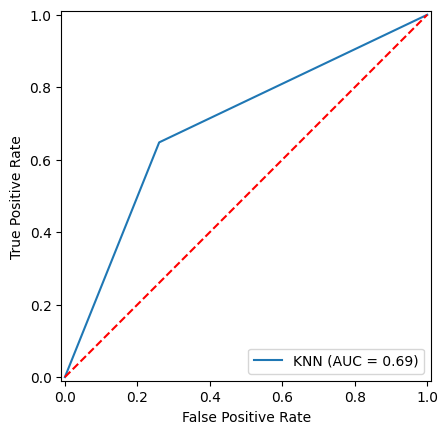

La accuracy del modelo KNN (2004) es: 0.7334


In [79]:
knn04est = KNeighborsClassifier(n_neighbors=3)
knn04est.fit(x_train_04est, y_train_04)
y_pred_knn04est = knn04est.predict(x_test_04est)

#Medidas de precision KNN (2004)
confknn04est = confusion_matrix(y_test_04, y_pred_knn04est) 
print("Matriz de confusion (KNN 2004)\n", confknn04est)

#AUC
auc_knn04est = roc_auc_score(y_test_04, y_pred_knn04est)
print('\nAUC KNN (2004): %.4f' %auc_knn04est)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_knn04est)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_knn04est, estimator_name='KNN')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_knn04est = accuracy_score(y_test_04, y_pred_knn04est)
print("La accuracy del modelo KNN (2004) es: %.4f" %accuracy_knn04est)

##### 2024 estandarizado

Matriz de confusion (KNN 2024)
 [[1966   22]
 [  69   31]]

AUC KNN (2024): 0.6495


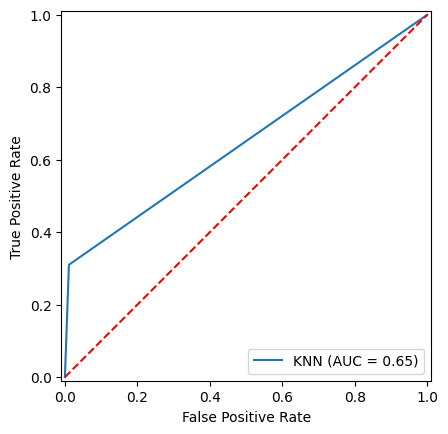

La accuracy del modelo KNN (2024) es: 0.9564


In [80]:
knn24est = KNeighborsClassifier(n_neighbors=3)
knn24est.fit(x_train_24est, y_train_24)
y_pred_knn24est = knn24est.predict(x_test_24est)

#Medidas de precision KNN (2004)
confknn24est = confusion_matrix(y_test_24, y_pred_knn24est) 
print("Matriz de confusion (KNN 2024)\n", confknn24est)

#AUC
auc_knn24est = roc_auc_score(y_test_24, y_pred_knn24est)
print('\nAUC KNN (2024): %.4f' %auc_knn24est)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_knn24est)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_knn24est, estimator_name='KNN')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_knn24est = accuracy_score(y_test_24, y_pred_knn24est)
print("La accuracy del modelo KNN (2024) es: %.4f" %accuracy_knn24est)

#### NAIVE BAYES


In [81]:
from sklearn.naive_bayes import GaussianNB

In [82]:
#### NB para 2004
nb04 = GaussianNB() 
nb04 = nb04.fit(x_train_04, y_train_04)
y_pred_nb04 = nb04.predict(x_test_04)

#### NB para 2024
nb24 = GaussianNB() 
nb24 = nb24.fit(x_train_24, y_train_24)
y_pred_nb24 = nb24.predict(x_test_24)

Matriz de confusion (NB 2004)
 [[2051   82]
 [   2  157]]

AUC NB (2004): 0.9745


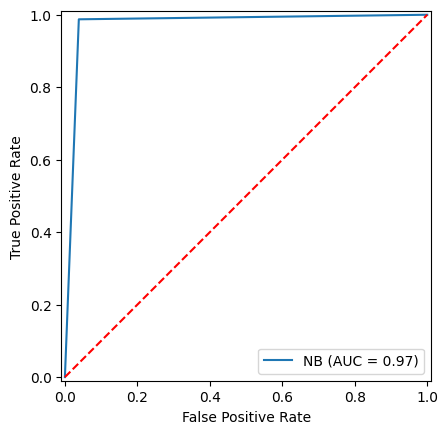

La accuracy del modelo NB (2004) es: 0.9634


In [83]:
#Medidas de precision Naive Bayes (2004)
confnb04 = confusion_matrix(y_test_04, y_pred_nb04) 
print("Matriz de confusion (NB 2004)\n", confnb04)

#AUC
auc_nb04 = roc_auc_score(y_test_04, y_pred_nb04)
print('\nAUC NB (2004): %.4f' %auc_nb04)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_nb04)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_nb04, estimator_name='NB')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_nb04 = accuracy_score(y_test_04, y_pred_nb04)
print("La accuracy del modelo NB (2004) es: %.4f" %accuracy_nb04)

Matriz de confusion (NB 2024)
 [[ 735 1253]
 [   4   96]]

AUC NB (2024): 0.6649


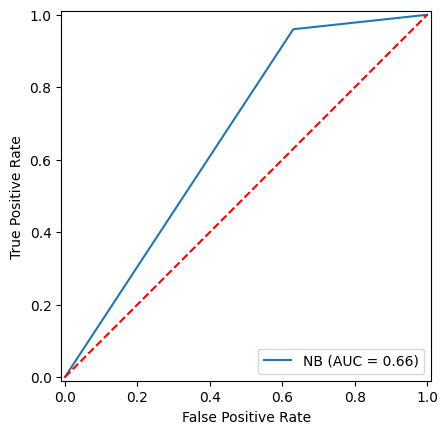

La accuracy del modelo NB (2024) es: 0.3980


In [84]:
#Medidas de precision Naive Bayes (2024)
confnb24 = confusion_matrix(y_test_24, y_pred_nb24) 
print("Matriz de confusion (NB 2024)\n", confnb24)

#AUC
auc_nb24 = roc_auc_score(y_test_24, y_pred_nb24)
print('\nAUC NB (2024): %.4f' %auc_nb24)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_nb24)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_nb24, estimator_name='NB')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

#Accuracy
accuracy_nb24 = accuracy_score(y_test_24, y_pred_nb24)
print("La accuracy del modelo NB (2024) es: %.4f" %accuracy_nb24)

#### Predicciones

##### Predicción de Naive Bayes para 2004

In [85]:
y_pred_nb04 = nb04.predict(noresp_04)
y_pred_nba_04 = pd.Series(y_pred_nb04.tolist())
y_pred_nba_04.value_counts()

0    10
Name: count, dtype: int64

##### Predicción de KNN estandarizados para 2024

In [86]:
predKNN_noresp24 = knn24est.predict(noresp_24)
y_pred_KNN_24 = pd.Series(predKNN_noresp24.tolist())
y_pred_KNN_24.value_counts()

0    28
Name: count, dtype: int64